#Drone image classifer 
####by Kyle Koivuneva and Andrew Trac

This colab takes a dataset of drone images, individualy breaks the image down into components bases on an annotations file provided, and labels the entire image. To do so, a convolutional neural network is trained from scratch on thousands of portions of photos, where it can then be used to predict the labels of images the model has never seen.

##Setup

This project requires an annotation folder and an image folder, the path of these folders should be inserted into img_directory and annotations_directory. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_directory = './drive/MyDrive/finalProject/images/'                
annotations_directory = './drive/MyDrive/finalProject/annotations/'

IMG_SIZE = 224  

#Preprocessing

To train our model, images are broken down into many smaller images, one for each box specified in the annotations folder. These smaller images are then resized so that our model is given a predicable image input size, set to grayscale to decrease size, allowing us to load more images into ram at a time, and normalized.

In [ ]:
#Given a picture as a numpy array, a configuration file, and an output array, 
#Creates small snipits of the photo, and adds the charateristics of the file to the output array.
def get_components(npimg, annotations_path, output_array, photo_num):

  f = open(annotations_path,'r')
  all_lines = f.readlines()
  f.close()

  if(photo_num > 0):
    num_photos = 5   #prints images after preprocessing
  else:
    num_photos = 0

  for line in all_lines:

    line = line.split(',')

    top_left_x = int(line[0])
    top_left_y = int(line[1]) 
    width = int(line[2])
    height = int(line[3])

    score = int(line[4])
    object_category = int(line[5])
    truncation = int(line[6])
    occlusion = line[7]
    occlusion = int(occlusion[0:-1])

    focused_image = npimg[top_left_y:(top_left_y+ height),top_left_x:(top_left_x+ height)]  #Get the image only where the box is.

    resize = cv2.resize(focused_image, (IMG_SIZE,IMG_SIZE))

    if(num_photos > 0):   #Prints preprocessed photos for demo purposes.
       cv2_imshow(resize)
       num_photos = num_photos - 1
    
    resize = np.true_divide(resize, 255.0)  #normalizes the pixel values.
 
    output_array.append([resize, score, object_category, truncation, occlusion])    #Resize all images
 
  return

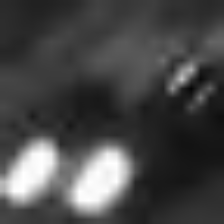

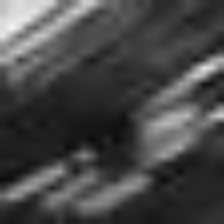

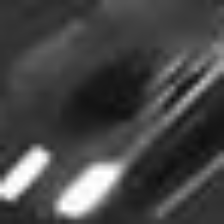

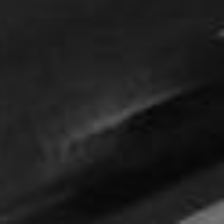

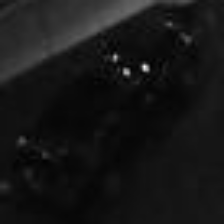

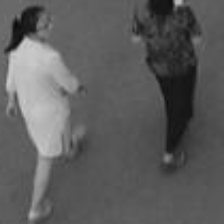

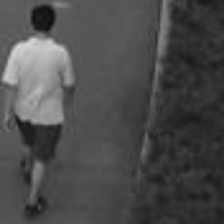

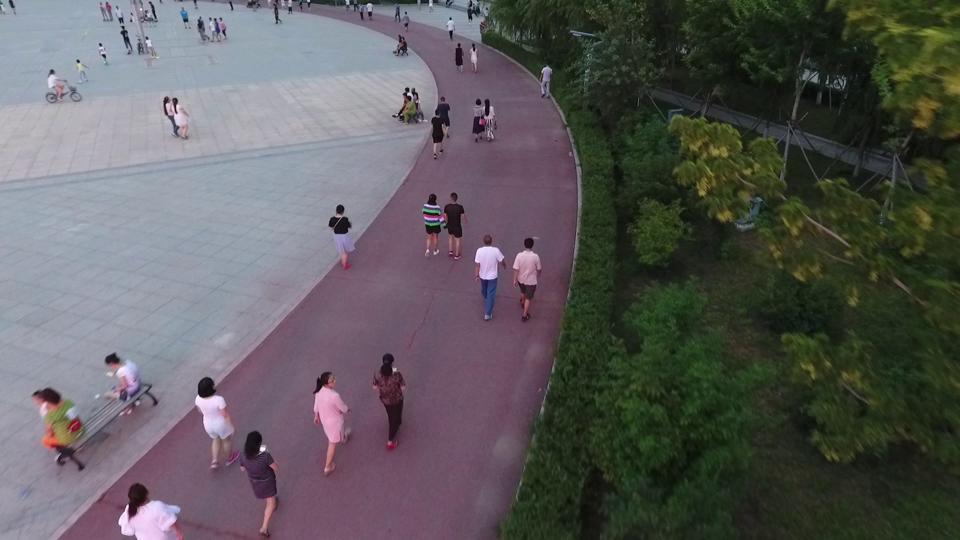

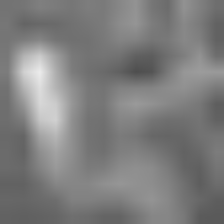

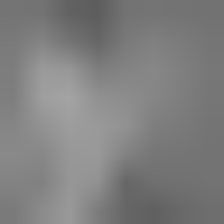

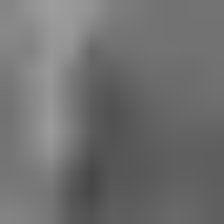

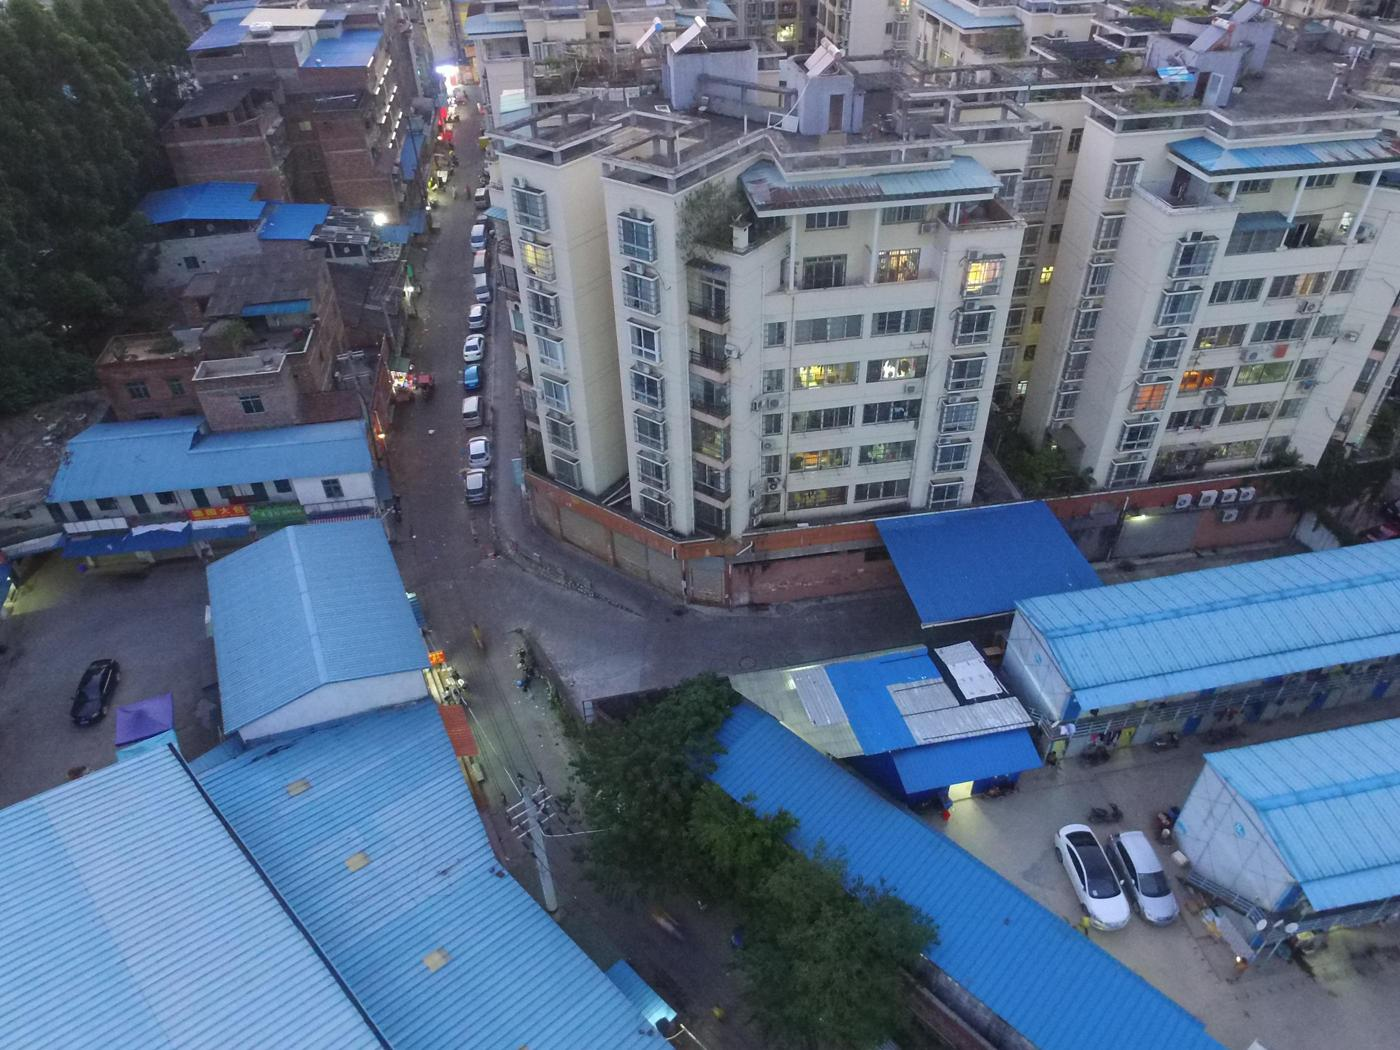

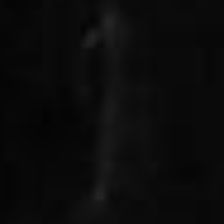

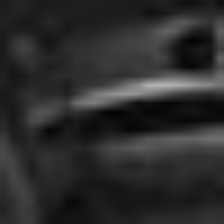

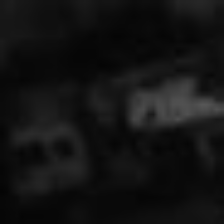

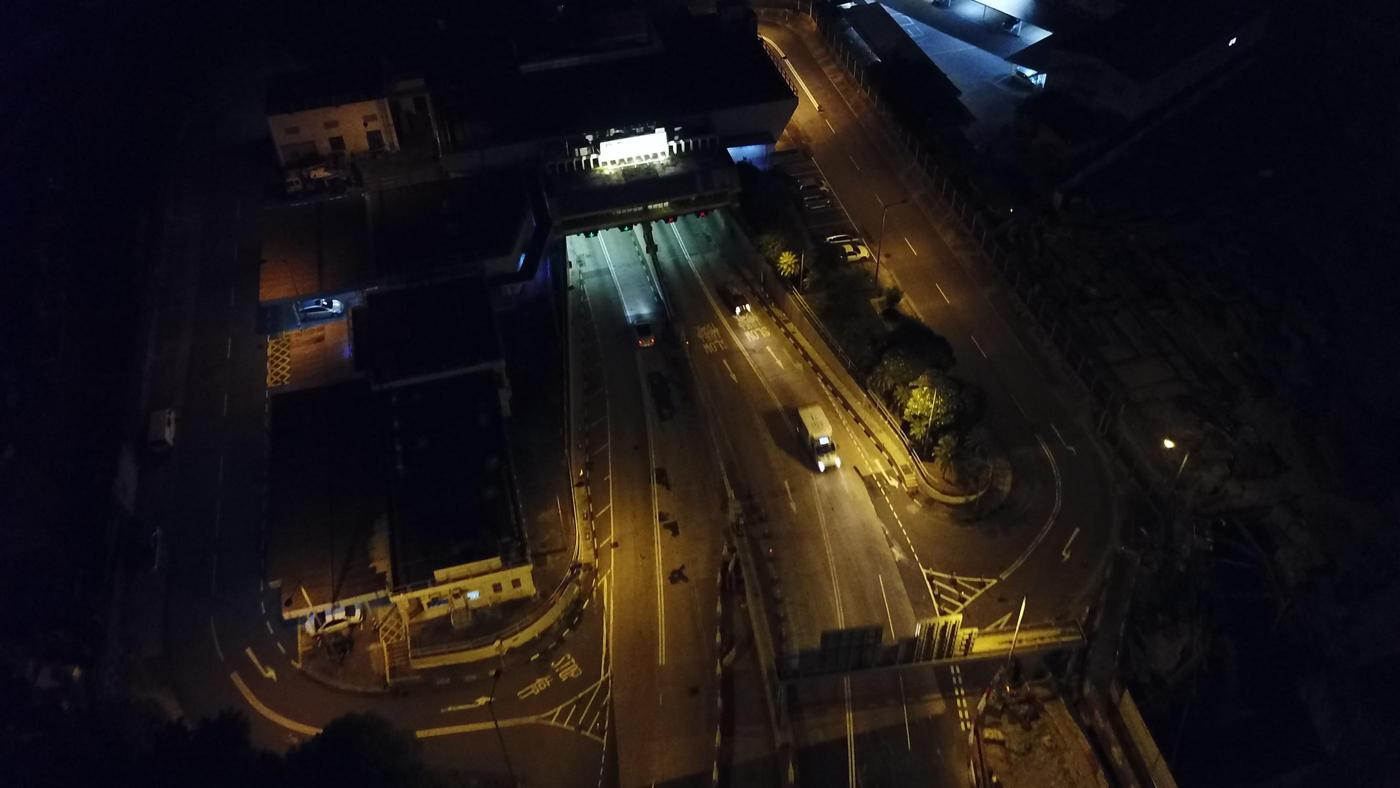

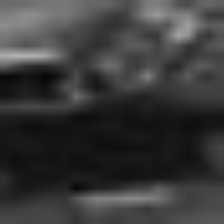

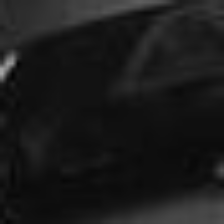

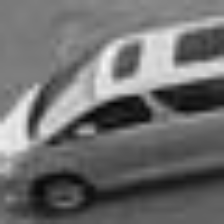

In [ ]:
import os
from PIL import Image
import numpy as np

import cv2

from google.colab.patches import cv2_imshow   #shows images in juniper notebooks.

counter = 200     #max number of pictures to sample (set higher if you have more memory)
photo_num = 5    #shows some photos for demo purposes

training_data=[]

for image_name in os.listdir(img_directory):
  shortened_image_name = image_name[0:-4]

  for file_name in os.listdir(annotations_directory):
      shortened_anno_name = file_name[0:-4]
  
      if (shortened_image_name == shortened_anno_name):
         
          img_array = cv2.imread(os.path.join(img_directory, image_name), cv2.IMREAD_GRAYSCALE)  
          get_components(img_array, os.path.join(annotations_directory,file_name) ,training_data, photo_num)

          if(photo_num > 0):
            cv2_imshow(cv2.imread(os.path.join(img_directory, image_name), cv2.IMREAD_COLOR))   #display some photos
            photo_num = photo_num -1
            
  counter = counter -1 
  if(counter <= 0):
    break

#Setting up test and validation sets

The data has now been preprocessed, we shuffle the data and split the data into a train and test set.

In [ ]:
import random
X = []
Y = []

random.shuffle(training_data)

for focused_image, score, object_category, truncation, occlusion in training_data:
    X.append(focused_image)
    Y.append(object_category)

print("Number of sample images: " + str(len(X)))

train = int(len(X)*0.7)
X_train = X[0:train]
X_test = X[train:]

Y_train = Y[0:train]
Y_test = Y[train:]

X_train = np.array(X_train)
X_test = np.array(X_test)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Number of sample images: 9163


#Creating our model

Out model consists of three convolutional layers followed by maxpooling layers. We encorporate two dense layers with dropout, to encourage the training of all neurons. The output is a 12 neuron softmax, coorosponding to the 12 different classes of objects the model is capable of recognizing. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import tensorflow as tf

model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE, 1)))   #1 for monochrome color
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(12, activation='softmax'))   #11 output neurons for the 11 classes.


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

#Results

Currently our model overfits, however this is mostly due to a lack of memory. We have found through testing that increasing the number of training examples increases the validation accuracy more and more, however increasing the training examples size any further will likely cause colab to crash, as colab limits users to 16gb of memory.

In [ ]:
model.fit(x=X_train, y=Y_train, validation_data = (X_test, Y_test), batch_size=10, epochs=20)

Epoch 1/20
529/529 [==============================] - 327s 616ms/step - loss: 1.8103 - accuracy: 0.3564 - val_loss: 1.6653 - val_accuracy: 0.4066
Epoch 2/20
529/529 [==============================] - 324s 613ms/step - loss: 1.5901 - accuracy: 0.4360 - val_loss: 1.5384 - val_accuracy: 0.4667
Epoch 3/20
529/529 [==============================] - 323s 611ms/step - loss: 1.3920 - accuracy: 0.5132 - val_loss: 1.4644 - val_accuracy: 0.4843
Epoch 4/20
529/529 [==============================] - 323s 611ms/step - loss: 1.1445 - accuracy: 0.5946 - val_loss: 1.6541 - val_accuracy: 0.4887
Epoch 5/20
529/529 [==============================] - 323s 611ms/step - loss: 0.9004 - accuracy: 0.6838 - val_loss: 1.5847 - val_accuracy: 0.5267
Epoch 6/20
321/529 [=================>............] - ETA: 1:56 - loss: 0.7002 - accuracy: 0.7523

In [ ]:
output_names = [
"regions", 
"pedestrian", 
"people",
"bicycle", 
"car", 
"van", 
"truck", 
"tricycle", 
"awning-tricycle", 
"bus", 
"motor", 
"others"
]

In [ ]:
import cv2

file_name = '0000086_01443_d_0000004'; #Image 1
#file_name = '0000107_00001_d_0000051'; #Image 2
#file_name = '0000137_00509_d_0000159'; #Image 3
#file_name = '9999947_00000_d_0000026'; #Image 4
#file_name = '9999964_00000_d_0000052'; #Image 5

img_directory = './drive/MyDrive/finalProject/images/'
annotations_directory = './drive/MyDrive/finalProject/annotations/'
img_path = img_directory + file_name + '.jpg'
annot_path = annotations_directory + file_name + '.txt'

image_large = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image_final = cv2.imread(img_path, cv2.IMREAD_COLOR)

color = (0, 255, 0)

thickness = 1

font = cv2.FONT_HERSHEY_SIMPLEX

with open(annot_path) as f:
   for line in f:
       x = line.split(',')

       start_point = (int(x[0]), int(x[1]))
       end_point = (int(x[0]) + int(x[2]), int(x[1]) + int(x[3]))


       top_left_x = int(x[0])
       top_left_y = int(x[1]) 
       width = int(x[2])
       height = int(x[3])
       
       focused_image = image_large[top_left_y:(top_left_y+ height),top_left_x:(top_left_x+ height)]  #Get the image only where the box is.
       
       resize = cv2.resize(focused_image, (IMG_SIZE,IMG_SIZE))    #Resize to what our model expects
       resize = np.true_divide(resize, 255.0)                     #Normalize
       resize = resize.reshape(1, 224, 224, 1)

       values = model.predict(resize)                             #Predict probabilities
       index_max = np.argmax(values)
    

       image_final = cv2.rectangle(image_final, start_point, end_point, color, thickness) #Draw boxes
       cv2.putText(image_final,output_names[index_max],(int(x[0]),int(x[1]) - 10), font, .5, (255, 255, 255), 1, cv2.LINE_AA) #Draw labels

cv2_imshow(image_final)